# Test model on various samples

In [68]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from random import randint
import numpy as np
import time
from scipy.stats import multivariate_normal
from math import floor, log2

from obb.model.oriented_reppoints_loss import OrientedRepPointsLoss

from obb.model.custom_model import *
from obb.utils.dataset import *
from obb.utils.polygon import *
from obb.utils.box_ops import min_area_rect, gaussian_to_xywha, xywha_to_xyxy, rep_points_to_gaussian, xyxy_to_xywha

# set plot deafult values
plt.matplotlib.rc('grid', linestyle = 'dotted', linewidth=1.5, alpha = 0.25)
plt.matplotlib.rc('font', family='serif', size=11)
plt.matplotlib.rc('legend', fontsize=11)

# Change ticks
plt.rcParams['xtick.major.size'] = 7.0
plt.rcParams['xtick.minor.size'] = 3.0
plt.rcParams['xtick.direction'] = 'inout'
plt.rcParams['ytick.major.size'] = 7.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['ytick.direction'] = 'inout'
colors = ['#0051a2', '#97964a', '#ffd44f', '#f4777f', '#ad8966', ]

Epoch 1: 0.547861
Epoch 2: 0.404898
Epoch 3: 0.371566
Epoch 4: 0.351561
Epoch 5: 0.341587
Epoch 6: 0.333829
Epoch 7: 0.324830
Epoch 8: 0.315200
Epoch 9: 0.312631
Epoch 10: 0.305077
Epoch 11: 0.304155
Epoch 12: 0.298800
Epoch 13: 0.295684
Epoch 14: 0.293442
Epoch 15: 0.289303
Epoch 16: 0.255605
Epoch 17: 0.248106
Epoch 18: 0.244985
Epoch 19: 0.242726
Epoch 20: 0.240916


ValueError: x and y must have same first dimension, but have shapes (10,) and (20,)

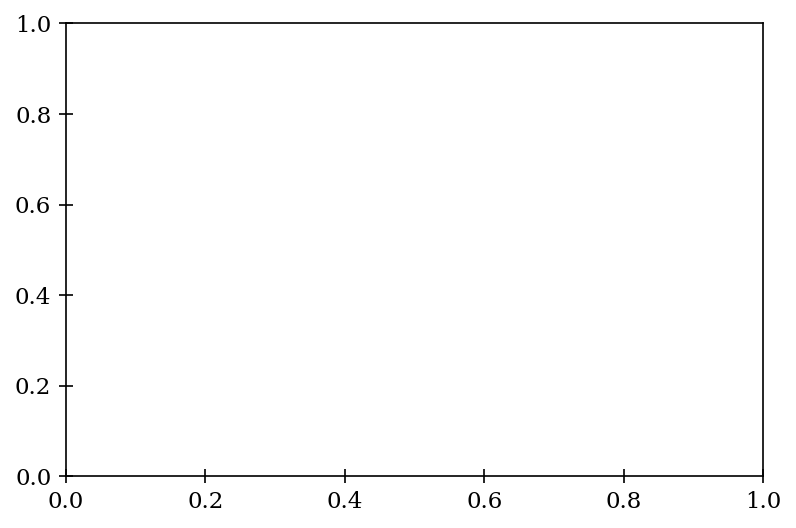

In [164]:
# Plot training loss
num_epochs = 20
epoch_step = 1

loss_lst = []

for epoch in range(epoch_step, num_epochs + epoch_step, epoch_step):
    checkpoint = torch.load(f'../src/obb/model/checkpoints/epoch_{epoch}.pt', map_location=torch.device('cpu'))
    loss_lst.append(checkpoint['loss'])
    print(f"Epoch {epoch}: {checkpoint['loss']:.6f}")
    del checkpoint

fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.add_subplot(1, 1, 1)
ax.plot(range(epoch_step, num_epochs + epoch_step, 2 * epoch_step), loss_lst)
ax.set_xticks(range(1, num_epochs + epoch_step, epoch_step))
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
plt.show()

In [160]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

epoch = 20  # Most recent epoch

# Load trained weights to detector
checkpoint = torch.load(f'../src/obb/model/checkpoints/epoch_{epoch}.pt', map_location=torch.device('cpu'))
model = DetectionModel().to(device)
model.load_state_dict(checkpoint['state_dict'])
model.eval()

# Create loss instance
rep_points_loss = OrientedRepPointsLoss(strides=model.feature_map_strides)

Using cache found in C:\Users\matan/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2022-4-24 torch 1.10.0+cpu CPU

Fusing layers... 
Model summary: 290 layers, 21640929 parameters, 0 gradients
Adding AutoShape... 


torch.Size([271, 8])
torch.Size([271, 2]) torch.Size([271, 2, 2])
torch.Size([32, 8])
torch.Size([32, 2]) torch.Size([32, 2, 2])
torch.Size([11, 8])
torch.Size([11, 2]) torch.Size([11, 2, 2])
torch.Size([7, 8])
torch.Size([7, 2]) torch.Size([7, 2, 2])


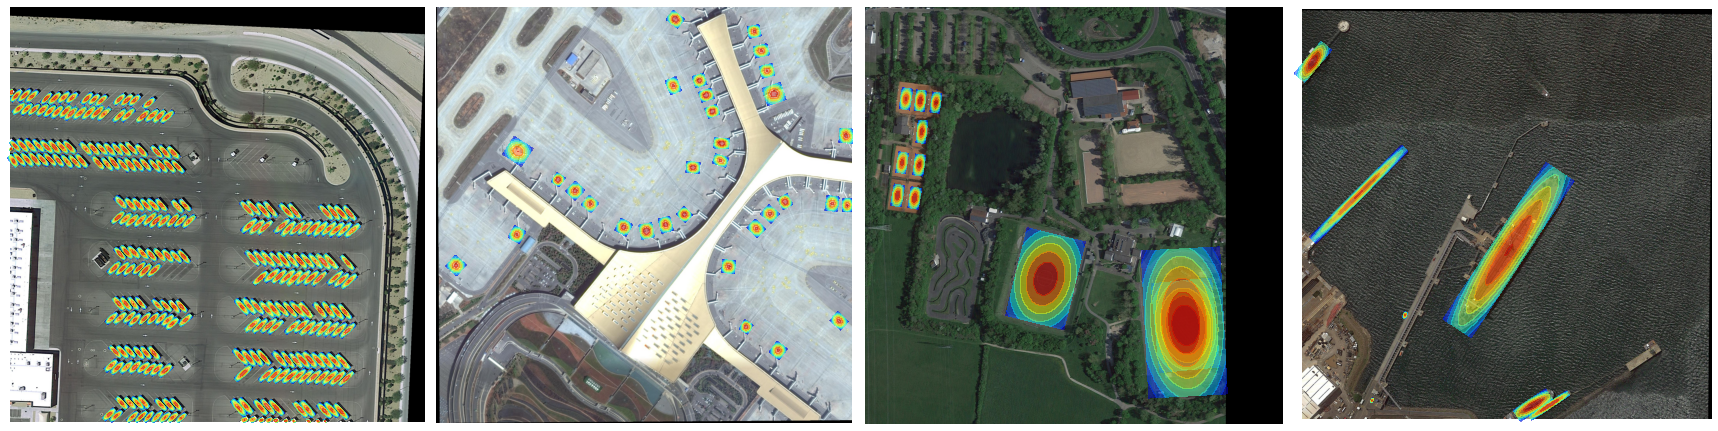

In [181]:
# Load sample dataset
train_dataset = Dataset(path='../assets/DOTA_sample_data/sample')
train_data_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)

fig = plt.figure(figsize=(24, 8))
num_imgs = len(train_data_loader)
for idx, (img, obb, object_class) in enumerate(train_data_loader):
    img = img.to(device)
    mu, S = rep_points_to_gaussian(obb.reshape(-1, 4, 2))
    obb = obb.squeeze(dim=0)
    print(obb.shape)
    print(mu.shape, S.shape)
    ax = fig.add_subplot(1, len(train_data_loader), idx + 1)
    ax.imshow(img.squeeze().permute(1, 2, 0).numpy())

    obb_xywha = torch.zeros(obb.shape[0], 6)
    for i, bbox in enumerate(obb):
        obb_xywha[i] = torch.Tensor(xyxy_to_xywha(bbox.reshape(-1, 2)))

        x0, y0, w, h, c, s = obb_xywha[i]
        x, y = np.arange(-0.5*w, 0.5*w, 0.1), np.arange(-0.5*h, 0.5*h, 0.1)
        xx, yy = np.meshgrid(x, y)
        xx, yy = c * xx - s * yy, s * xx + c * yy
        xx += x0
        yy += y0
        pos = np.dstack((xx, yy))
        rv1 = multivariate_normal(mean=mu[i], cov=S[i])
        rv2 = multivariate_normal(mean=mu[i], cov=S[i])

        ax.contourf(xx, yy, rv1.pdf(pos), alpha=0.5, cmap='jet')

    ax.set_axis_off()

plt.tight_layout()

Feeding image #1...
Loss: 1.1901
Classification: 0.0128
Localization init: 1.0347
Spatial constraint init: 0.0000
Regression refine: 0.6599
Class precisions:
['0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '1.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000']
Class recalls:
['0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '1.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000']
Feeding image #2...
Loss: 1.5465
Classification: 0.0000
Localization init: 1.0567
Spatial constraint init: 0.0000
Regression refine: 1.0182
Class precisions:
['1.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000']
Class recalls:
['1.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000']
Feeding image #3...
Loss: 1.4190
Classification: 0

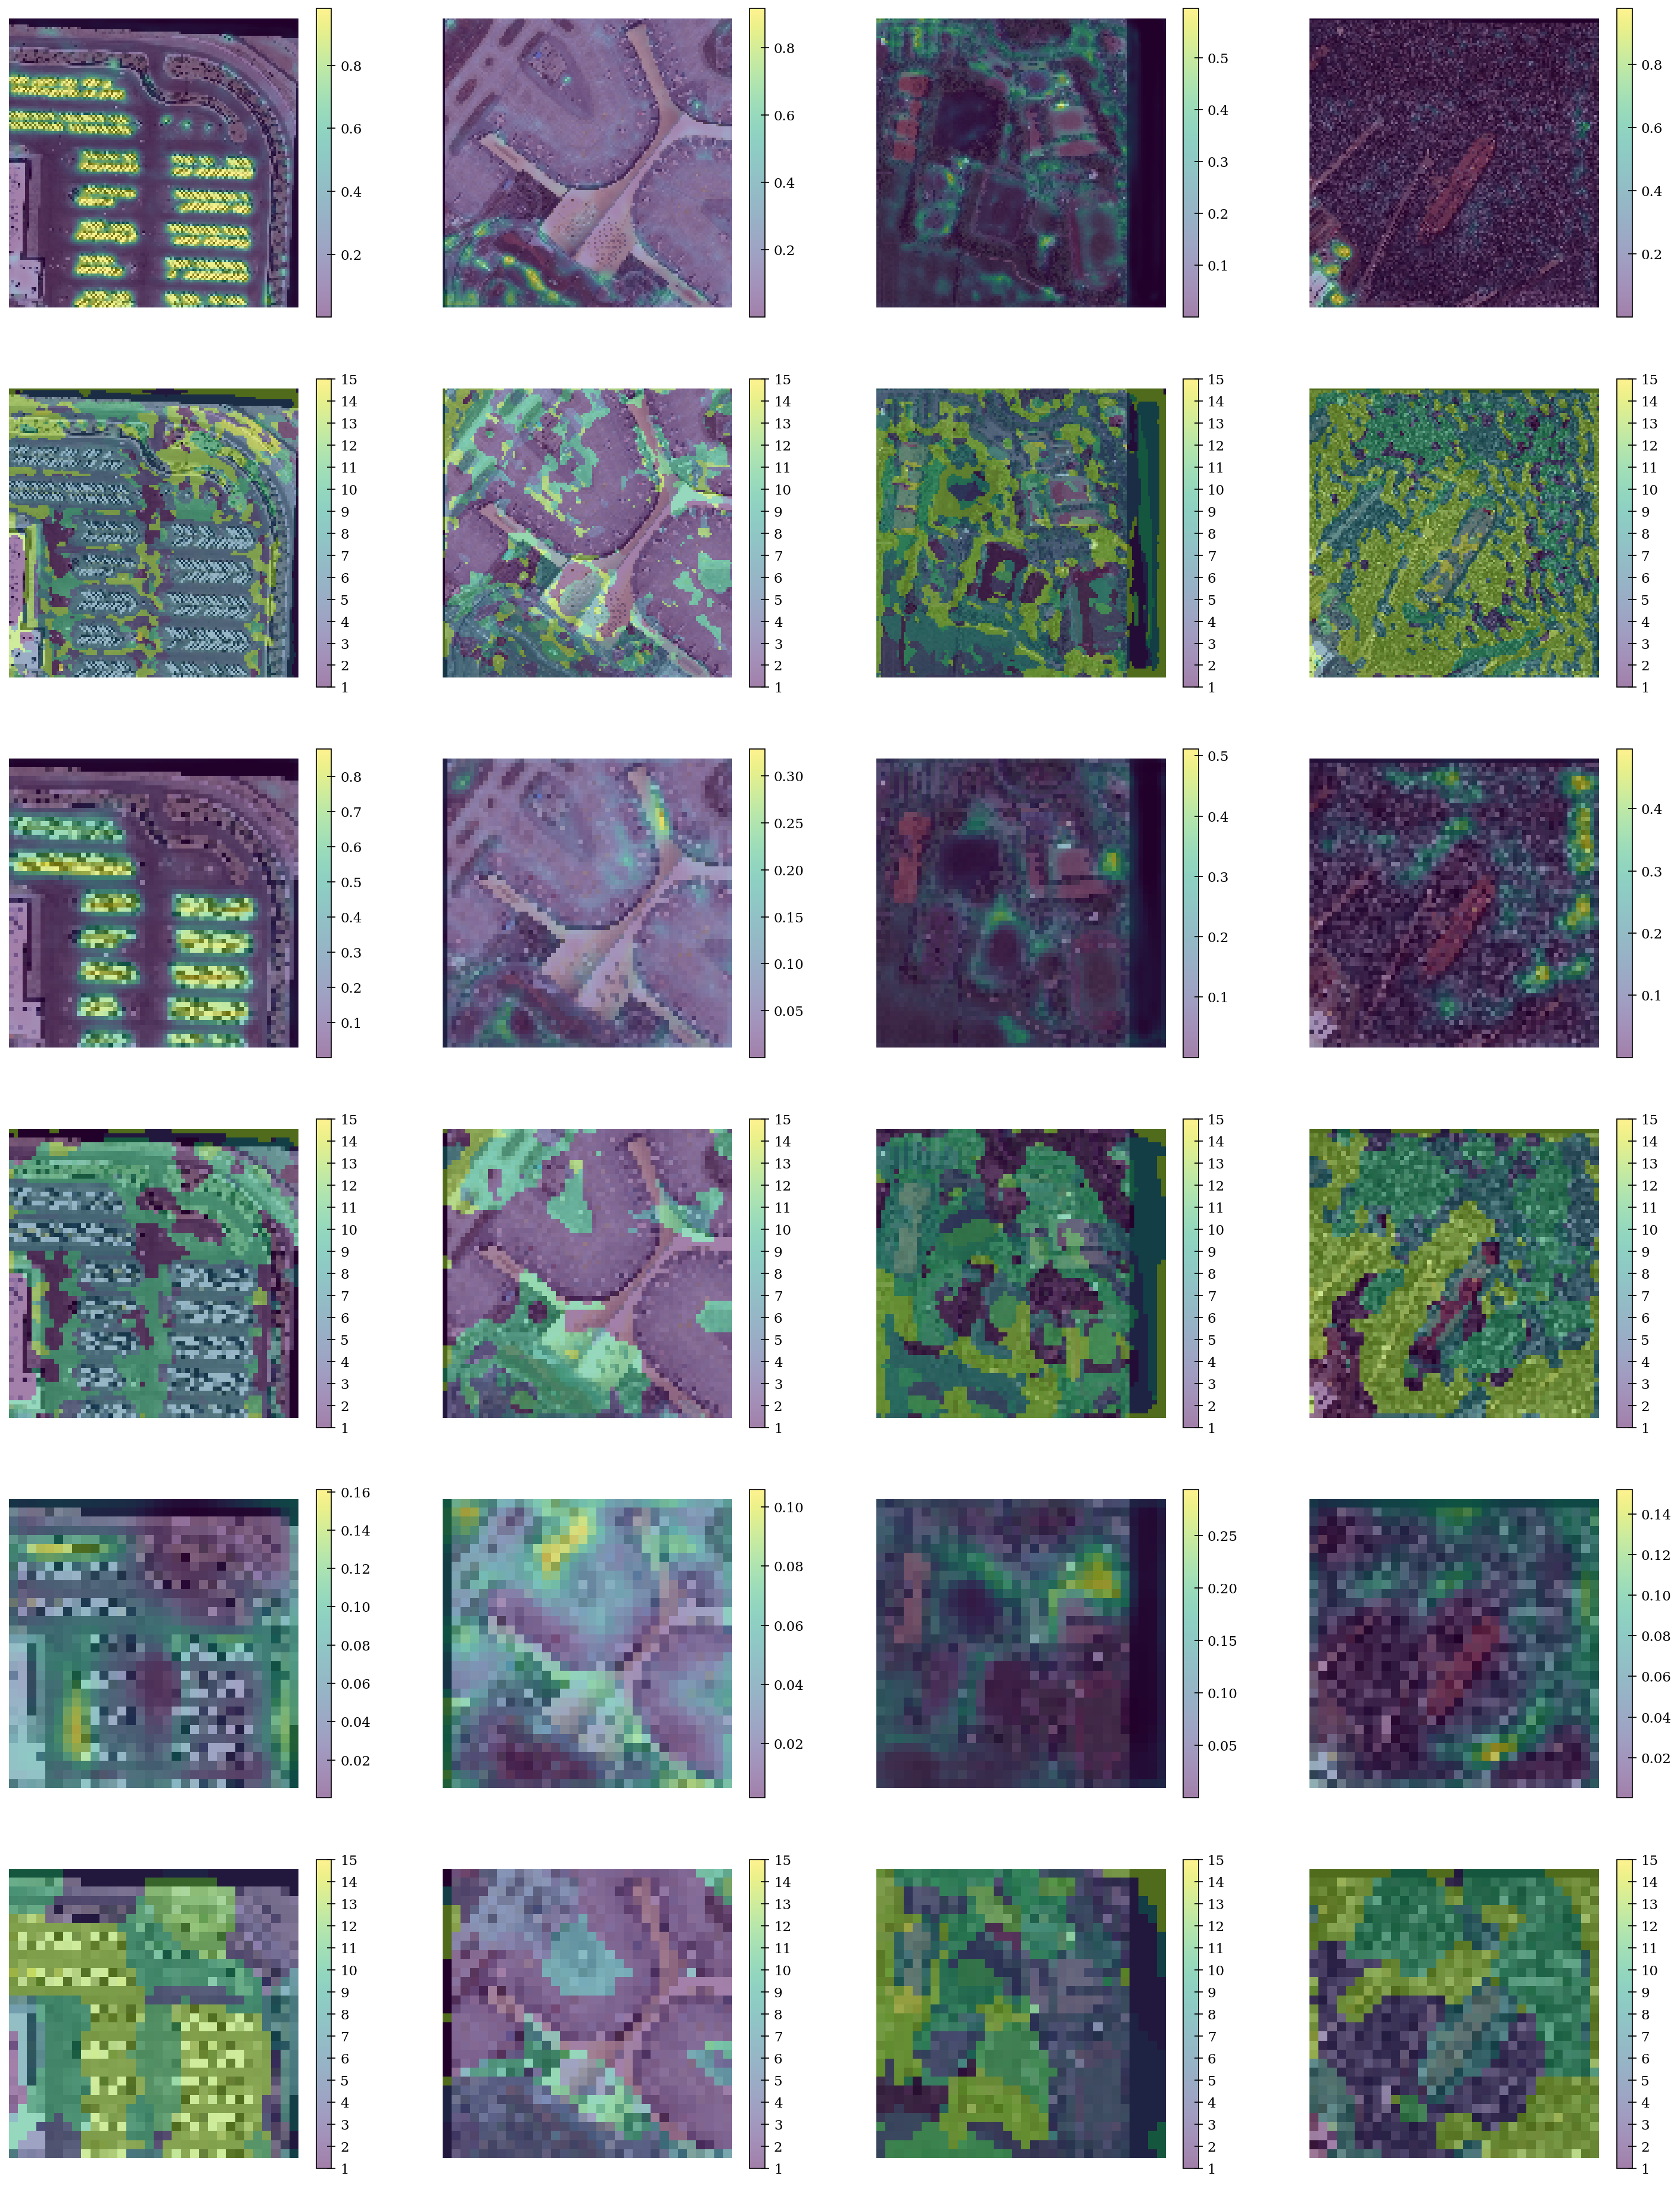

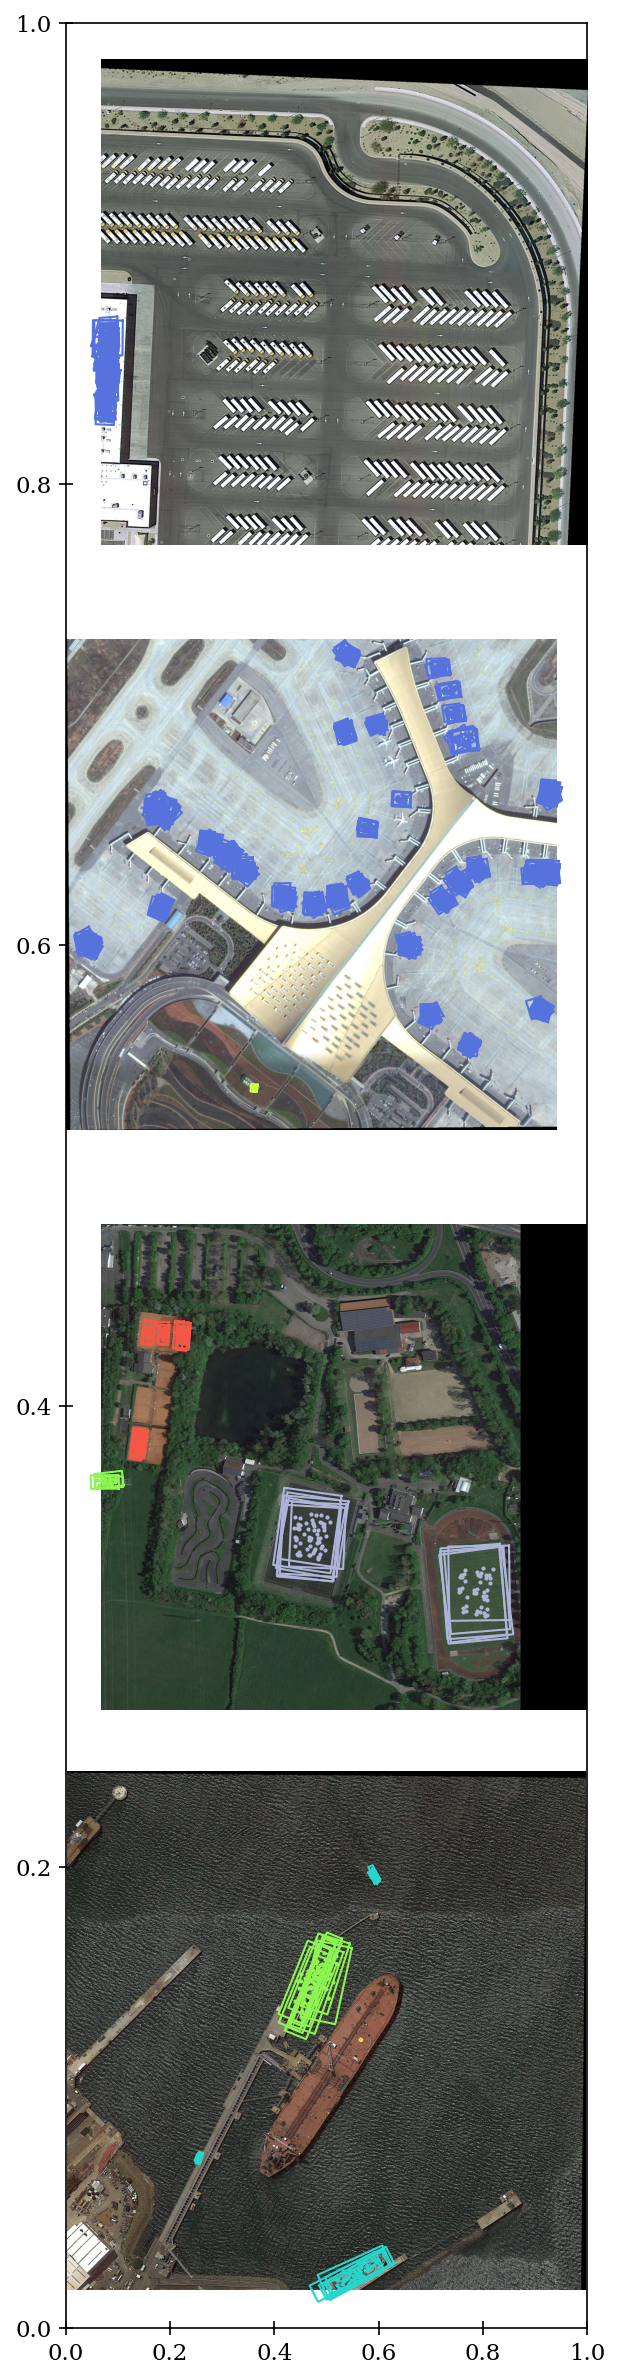

In [197]:
colors = []

for i in range(1, 16):
    colors.append('#%06X' % randint(0, 0xFFFFFF))

# Classification thresholds
threshold_dict = {
    'P3': 0.99,
    'P4': 0.99,
    'P5': 0.99
}

# Feature map strides
stride_dict = {'P3': 8, 'P4': 16, 'P5': 32}

# Get feature maps
fig = plt.figure(figsize=(24, 32), dpi=150)
fig1 = plt.figure(figsize=(4, 16), dpi=150)
for idx, (img, obb, object_class) in enumerate(train_data_loader):
    print(f'Feeding image #{idx+1}...')

    img = img.to(device)
    obb = obb.squeeze(dim=0)
    object_class = object_class.squeeze(dim=0)

    rep_points_init, rep_points_refine, classification = model(img)

    loss, loss_dict = rep_points_loss.get_loss(rep_points_init, rep_points_refine, classification, obb, object_class)

    print(f"Loss: {float(loss):.4f}")
    print(f"Classification: {float(loss_dict['classification']):.4f}")
    print(f"Localization init: {float(loss_dict['localization_init']):.4f}")
    print(f"Spatial constraint init: {float(loss_dict['spatial_constraint_init']):.4f}")
    print(f"Regression refine: {float(loss_dict['regression_refine']):.4f}")
    print('Class precisions:')
    print([f'{float(prc):.4f}' for prc in loss_dict['precision']])
    print('Class recalls:')
    print([f'{float(rcl):.4f}' for rcl in loss_dict['recall']])

    num_lvls = len(classification.keys())
    for lvl_idx, lvl in enumerate(classification.keys()):
        stride = stride_dict[lvl]  # Stride of current level

        # Get classification
        cls = torch.softmax(classification[lvl][0], dim=0)
        cls_hard = torch.argmax(classification[lvl][0], dim=0) + 1

        # Classification (probability)
        ax = fig.add_subplot(2 * num_lvls, len(train_data_loader), 2 * num_imgs * lvl_idx + idx + 1)
        ax.imshow(img.squeeze().permute(1, 2, 0)[::stride, ::stride].numpy())
        class_map = ax.imshow(cls[5].detach().numpy(), alpha=0.5)
        ax.set_axis_off()
        plt.colorbar(class_map, ax=ax)

        # Classification (hard)
        ax = fig.add_subplot(2 * num_lvls, len(train_data_loader), 2 * num_imgs * lvl_idx + idx + 1 + num_imgs)
        ax.imshow(img.squeeze().permute(1, 2, 0)[::stride, ::stride].numpy())
        class_map = ax.imshow(cls_hard.detach().numpy(), vmin=1, vmax=15, alpha=0.5)
        ax.set_axis_off()
        plt.colorbar(class_map, ax=ax, ticks=range(1, 16))

    # Localization
    ax = fig1.add_subplot(len(train_data_loader), 1, idx + 1)
    ax.imshow(img.squeeze().permute(1, 2, 0).numpy())
    for lvl_idx, lvl in enumerate(classification.keys()):
        stride = stride_dict[lvl]  # Stride of current level

        cls, pts = torch.softmax(classification[lvl][0], dim=0), rep_points_refine[lvl][0]
        cls_hard = torch.argmax(cls, dim=0).to(int) + 1
        for i in range(0, pts.shape[1], 1):
            for j in range(0, pts.shape[2], 1):
                pt_set = pts[:, i, j].reshape(-1, 2)
                if cls[cls_hard[i, j] - 1, i, j] > threshold_dict[lvl]:
                    mu, S = rep_points_to_gaussian(pt_set.unsqueeze(dim=0))
                    rect_xywha = gaussian_to_xywha(mu, S)
                    rect = xywha_to_xyxy(rect_xywha)[0].reshape(-1, 2)
                    ax.scatter(pt_set[:, 0].detach().numpy(), pt_set[:, 1].detach().numpy(), s=1, color=colors[cls_hard[i, j] - 1])
                    ax.plot(torch.cat((rect[:, 0], rect[0, 0].reshape(1))).detach().numpy(),
                            torch.cat((rect[:, 1], rect[0, 1].reshape(1))).detach().numpy(),
                            linewidth=1, color=colors[cls_hard[i, j] - 1])
                    # ax.scatter([j * stride], [i * stride], s=4)

    ax.set_axis_off()

plt.tight_layout()